# Imports

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Data conversion between R and Python
import rpy2

# Options for pandas
pd.options.display.max_columns = 100
pd.options.display.max_rows = 30
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))

# Stats
from scipy import stats
from scipy.stats import norm, skew

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()
import expectexception

# Autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

# Visualizations
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import seaborn as sns

# Load ipywidgets module
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

# Activate the automatic conversion for pandas
from rpy2.robjects import pandas2ri
pandas2ri.activate()

# Load the needed extension for the %%R cell magic
%load_ext rpy2.ipython
import rpy2.robjects as robjects

# Bayesian Optimization
import GPy
import GPyOpt
from GPyOpt.methods import BayesianOptimization
from skopt import BayesSearchCV

# Suppress Sklearn warnings
import warnings
warnings.simplefilter('ignore')

# Sklearn
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import ElasticNet, Lasso
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error

# Additional ML libraries
import xgboost as xgb
from mlxtend.regressor import StackingRegressor

 /Users/nelson/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning:sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.


In [2]:
%%R

# load the r library
library(ggplot2)
library(ggalt)
theme_set(theme_light())

library(scales)
library(dplyr)

# Data Cleaning

In [3]:
# import datasets
train_raw = pd.read_csv('./data/train.csv')
test_raw = pd.read_csv('./data/test.csv')

# Save test_ID as a series 
test_ID = test_raw.Id

# drop ID columns
train_raw.drop('Id', axis=1, inplace=True)
test_raw.drop('Id', axis=1, inplace=True)

## Outliers

In [4]:
AreaVSPrice = train_raw[['GrLivArea', 'SalePrice']]

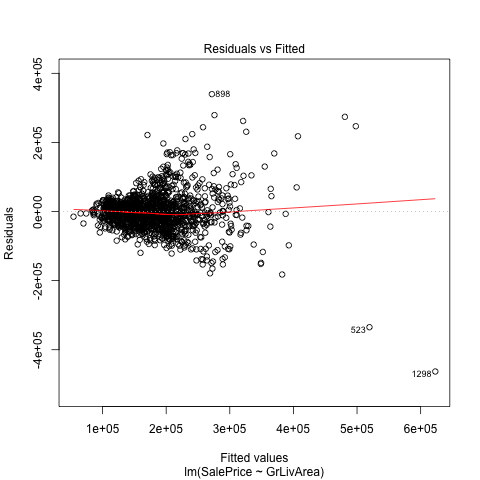

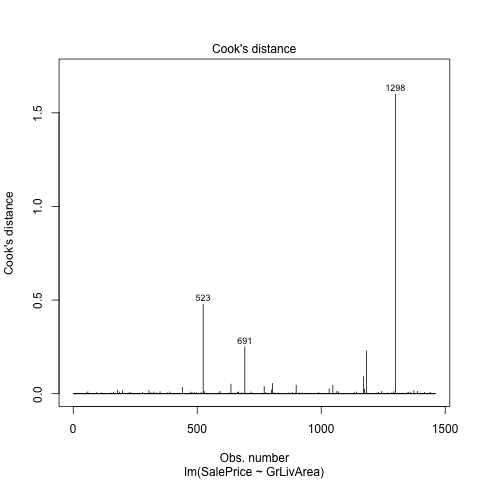

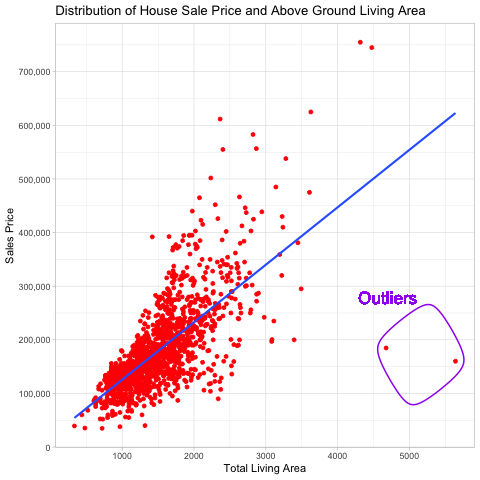

In [5]:
%%R -i AreaVSPrice

# Check residual plots and look for potential outliers
linear_model = lm(SalePrice~GrLivArea, data=AreaVSPrice)
plot(linear_model, c(1, 4))

# Note that the dataframe index starts from 0 instead of 1
outliers = AreaVSPrice %>% slice(c(524, 1299))

ggplot(AreaVSPrice, aes(x=GrLivArea, y=SalePrice)) +
    geom_point(col='red') +
    geom_encircle(aes(x=GrLivArea, y=SalePrice), 
                  data=outliers,
                  col='purple',
                  size=2,
                  expand=0.02) +
    geom_text(x=4700, y=280000, label='Outliers', col='purple', size=6) +
    geom_smooth(method='lm', aes(group=1), se=F) +
    scale_y_continuous(breaks=seq(0, 800000, by=100000), labels=comma) +
    labs(title='Distribution of House Sale Price and Above Ground Living Area',
         x='Total Living Area',
         y='Sales Price')

In [6]:
# Drop the outliers
train_raw.drop(train_raw[train_raw.GrLivArea > 4500].index, inplace=True)

In [7]:
# concat the data
all_raw = pd.concat([train_raw, test_raw], ignore_index=True, sort=False)

In [8]:
AreaVSPrice_droppedOL = train_raw[['GrLivArea', 'SalePrice']]

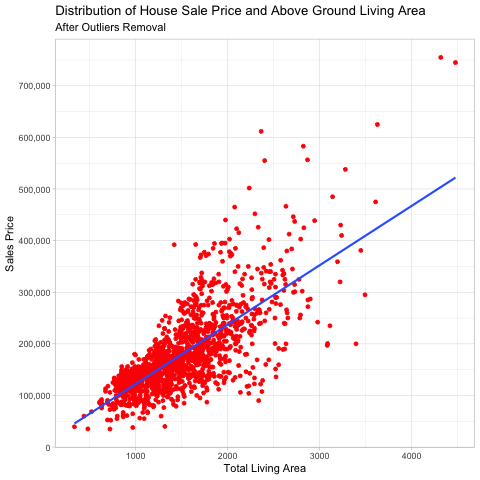

In [9]:
%%R -i AreaVSPrice_droppedOL

ggplot(AreaVSPrice_droppedOL, aes(x=GrLivArea, y=SalePrice)) +
    geom_point(col='red') +
    geom_smooth(method='lm', aes(group=1), se=F) +
    scale_y_continuous(breaks=seq(0, 800000, by=100000), labels=comma) +
    labs(title='Distribution of House Sale Price and Above Ground Living Area',
         subtitle='After Outliers Removal',
         x='Total Living Area',
         y='Sales Price')

## Missing Data

In [10]:
# Columns with nan
all_raw.loc[:, all_raw.isnull().any()].columns
missing_features = len(all_raw.loc[:, all_raw.isnull().any()].columns)
print ('There are {} columns with missing data'.format(missing_features))

Index(['MSZoning', 'LotFrontage', 'Alley', 'Utilities', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Electrical', 'BsmtFullBath',
       'BsmtHalfBath', 'KitchenQual', 'Functional', 'FireplaceQu',
       'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea',
       'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SalePrice'],
      dtype='object')

There are 35 columns with missing data


In [11]:
def exam_raw(df, nullcol, columns):
    '''
    Extract rows within a dataframe for null values within target columns
    df: input dataframe
    nullcol: the columns containing the null values
    columns: columns to be shown (as a list of strings)
    '''
    return df.loc[df[nullcol].isnull(), columns]

### Individual rows to impute

#### Masonry Variables

In [12]:
exam_raw(all_raw, 'MasVnrType', ['MasVnrType', 'MasVnrArea'])

,MasVnrType,MasVnrArea
234,NaN,nan
528,NaN,nan
649,NaN,nan
935,NaN,nan
972,NaN,nan
976,NaN,nan
1242,NaN,nan
1277,NaN,nan
1689,NaN,nan
1704,NaN,nan


In [13]:
# impute by mode other than 'None' because of existing area
all_raw.loc[2608, 'MasVnrType'] = all_raw.MasVnrType.value_counts().index[1]

In [14]:
all_raw.loc[2608, 'MasVnrType']

'BrkFace'

#### Basement Variables

In [15]:
nullcount = all_raw.isnull().sum()

# Null counts for basement related variables
Bsmt_null = nullcount.loc[nullcount.index.str.contains('Bsmt')].sort_values(ascending=False)
Bsmt_null

# Slice basement related variables with greater proportion of nulls
Bsmt_with_large_NAN = Bsmt_null.loc[Bsmt_null > 50].index

BsmtExposure    82
BsmtCond        82
BsmtQual        81
BsmtFinType2    80
BsmtFinType1    79
BsmtHalfBath     2
BsmtFullBath     2
TotalBsmtSF      1
BsmtUnfSF        1
BsmtFinSF2       1
BsmtFinSF1       1
dtype: int64

In [16]:
# Confirm that all missing observations in 'BsmtFinType1' also corresponds to other variables
all_raw.loc[all_raw.BsmtFinType1.isnull(), Bsmt_with_large_NAN].sum()

BsmtExposure   0.000
BsmtCond       0.000
BsmtQual       0.000
BsmtFinType2   0.000
BsmtFinType1   0.000
dtype: float64

In [17]:
# Select observations where 'BsmtFinType1' are complete but missing at other columns
all_raw.loc[all_raw.BsmtFinType1.notnull() & (all_raw.BsmtQual.isnull() | 
                                              all_raw.BsmtCond.isnull() | 
                                              all_raw.BsmtExposure.isnull() | 
                                              all_raw.BsmtFinType2.isnull()), 
            Bsmt_with_large_NAN]

,BsmtExposure,BsmtCond,BsmtQual,BsmtFinType2,BsmtFinType1
332,No,TA,Gd,NaN,GLQ
947,NaN,TA,Gd,Unf,Unf
1485,NaN,TA,Gd,Unf,Unf
2038,Mn,NaN,Gd,Rec,GLQ
2183,No,NaN,TA,Unf,BLQ
2215,No,Fa,NaN,Unf,Unf
2216,No,TA,NaN,Unf,Unf
2346,NaN,TA,Gd,Unf,Unf
2522,Av,NaN,TA,Unf,ALQ


In [18]:
def ModeImputer(df, indices, column):
    """
    Impute specific rows with column modes.
    df: input dataframe
    indices: indices of row (as a list of integers)
    column: column to be imputed
    """
    df.loc[indices, column] = df[column].mode()[0]

In [19]:
ModeImputer(all_raw, [947, 1485, 2346], 'BsmtExposure')
ModeImputer(all_raw, [2038, 2183, 2522], 'BsmtCond')
ModeImputer(all_raw, [2215, 2216], 'BsmtQual')
ModeImputer(all_raw, [332], 'BsmtFinType2')

#### Garage Variables

In [20]:
# Null counts for garage related variables
Garage_null = nullcount.loc[nullcount.index.str.contains('Garage')].sort_values(ascending=False)
Garage_null

# Slice basement related variables with greater proportion of nulls
Garage_var = Garage_null.index
Garage_with_large_NAN = Garage_null.loc[Garage_null > 100].index

GarageCond      159
GarageQual      159
GarageFinish    159
GarageYrBlt     159
GarageType      157
GarageArea        1
GarageCars        1
dtype: int64

In [21]:
# Confirm that all missing observations in 'GarageType' also corresponds to other variables
all_raw.loc[all_raw.GarageType.isnull(), Garage_with_large_NAN].sum()

GarageCond     0.000
GarageQual     0.000
GarageFinish   0.000
GarageYrBlt    0.000
GarageType     0.000
dtype: float64

In [22]:
# Select observations where 'GarageType' are complete but missing at other columns
all_raw.loc[all_raw.GarageType.notnull() & (all_raw.GarageCond.isnull() | 
                                              all_raw.GarageQual.isnull() | 
                                              all_raw.GarageFinish.isnull() | 
                                              all_raw.GarageYrBlt.isnull()), 
            Garage_var]

,GarageCond,GarageQual,GarageFinish,GarageYrBlt,GarageType,GarageArea,GarageCars
2124,NaN,NaN,NaN,nan,Detchd,360.000,1.000
2574,NaN,NaN,NaN,nan,Detchd,nan,nan


In [23]:
ModeImputer(all_raw, [2124], 'GarageCond')
ModeImputer(all_raw, [2124], 'GarageQual')
ModeImputer(all_raw, [2124], 'GarageFinish')

# Seems like obs 2574 doesn't really have a garage
all_raw.loc[2574, 'GarageType'] = np.nan

### Imputation for naturally non-existing data

In [24]:
# List of variables to be casted to none or zeroes
tonone = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu',
          'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
          'BsmtQual', 'BsmtCond', 'BsmtExposure', 
          'BsmtFinType1', 'BsmtFinType2', 'MasVnrType']

tozero = ['GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
          'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea']

In [25]:
for col in tonone:
    all_raw[col] = all_raw[col].fillna('None')

In [26]:
for col in tozero:
    all_raw[col] = all_raw[col].fillna(0)

### Imputation according to mode

In [27]:
# Impute Electrical to its mode
all_raw['Electrical'].fillna(all_raw['Electrical'].mode()[0], inplace=True)

### Random imputation

In [28]:
def random_impute(df, columns, seed):
    """
    Impute the missing values within categorical features according to proportion.
    df: input dataframe
    columns: columns to be imputed (as a list of strings)
    seed: random seed that's used
    """
    np.random.seed(seed)
    for column in columns:
        series = df[column].value_counts()
        proportion = series / series.sum()
        df[column] = df[column].fillna(np.random.choice(series.index, p=proportion))

In [29]:
random_impute(all_raw, ['MSZoning', 'SaleType',
                        'KitchenQual', 'Exterior1st', 'Exterior2nd'], 0)

### Dropping useless variables

In [30]:
all_raw.drop(['Utilities'], axis=1, inplace=True)

### Other imputations

In [31]:
# Impute Lot Frontage stratified by median values in different neighborhoods
all_raw['LotFrontage'] = all_raw.groupby('Neighborhood')['LotFrontage'].transform(
    lambda x: x.fillna(x.median()))

In [32]:
# Impute 'Garage year built' by 'House year built'
garage_df = exam_raw(all_raw, 'GarageYrBlt', ['GarageYrBlt', 'YearBuilt'])
all_raw.GarageYrBlt.fillna(garage_df.YearBuilt, inplace=True)

In [33]:
# Impute Functional as 'Typical'
all_raw["Functional"].fillna("Typ", inplace=True)

---

In [34]:
# Check to see if there're anymore missing values
all_raw.loc[:, all_raw.isnull().any()].columns

Index(['SalePrice'], dtype='object')

# Feature Engineering

## Casting numerical features to categorical

In [35]:
all_imputed = all_raw.copy()

In [36]:
tocat = ['MSSubClass', 'OverallCond', 'YrSold', 'MoSold']

In [37]:
for col in tocat:
    all_imputed[col] = all_imputed[col].astype(str)

## Adding variables

In [38]:
# Compute total Square Feet
all_imputed['TotalSF'] = all_imputed['TotalBsmtSF'] + \
    all_imputed['1stFlrSF'] + all_imputed['2ndFlrSF']

In [39]:
TotalSFVSPrive = all_imputed[['TotalSF', 'SalePrice']].dropna()
correlation = round(TotalSFVSPrive.corr().iloc[1,0], 3)
print('The correlation between Total SF and Sale Price is {}'.format(correlation))

The correlation between Total SF and Sale Price is 0.833


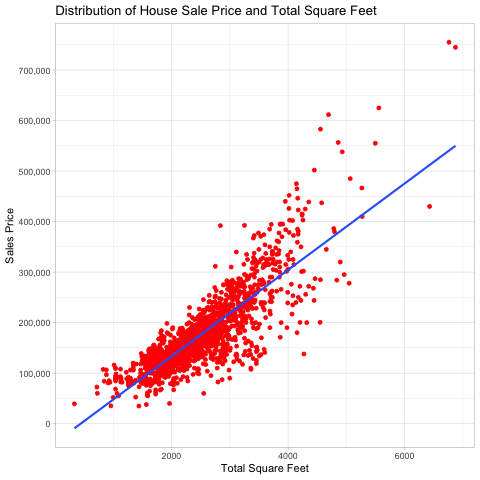

In [40]:
%%R -i TotalSFVSPrive

ggplot(TotalSFVSPrive, aes(x=TotalSF, y=SalePrice)) +
    geom_point(col='red') +
    geom_smooth(method='lm', aes(group=1), se=F) +
    scale_y_continuous(breaks=seq(0, 800000, by=100000), labels=comma) +
    labs(title='Distribution of House Sale Price and Total Square Feet',
         x='Total Square Feet',
         y='Sales Price')

In [41]:
# Inflation index for Ames obtained through external site
inflationindex = {
    '2006': 240.85,
    '2007': 246.07,
    '2008': 247.23,
    '2009': 247.03,
    '2010': 245.29
}

all_imputed['InflationIndex'] = all_imputed['YrSold'].map(inflationindex)

## Transforming variables

### Features

In [42]:
# Select highly skewed features
numerical_features = all_imputed.select_dtypes('number').columns
skewness = all_imputed[numerical_features].apply(lambda x: skew(x))
skewed_features = skewness[abs(skewness) > 1.5]
print('There are {} skewed features to be transformed'.format(len(skewed_features)))

# Handle rows with zeroes
skewed_features_addone = all_imputed[skewed_features.index] + 1

There are 13 skewed features to be transformed


In [43]:
# Apply boxcox transformation to all variables with skewness > 1.5
for features in skewed_features.index:
    all_imputed[features], _ = stats.boxcox(
        skewed_features_addone[features])

### Target Variable

In [44]:
price = all_imputed[['SalePrice']].dropna()

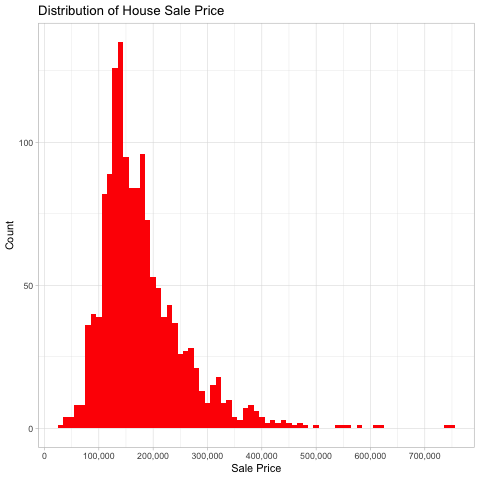

In [45]:
%%R -i price

ggplot(price, aes(x=SalePrice)) + 
    geom_histogram(fill='red', binwidth=10000) +
    scale_x_continuous(breaks=seq(0, 800000, by=100000), labels=comma) +
    labs(title='Distribution of House Sale Price',
         x='Sale Price',
         y='Count')

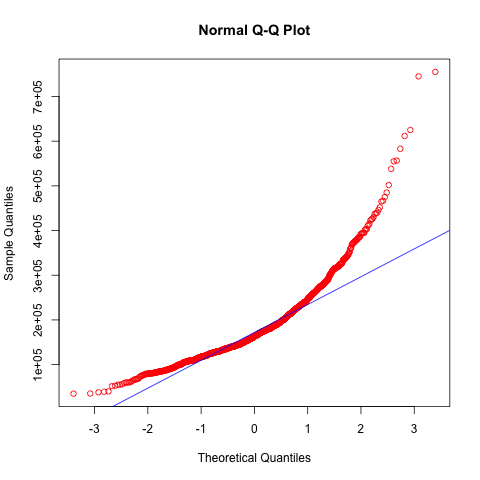

In [46]:
%%R -i price

qqnorm(price$SalePrice, col='red')
qqline(price$SalePrice, col='blue')

In [47]:
# log-transformed Sale Price
all_imputed['SalePrice'] = np.log1p(all_imputed['SalePrice'])
price = all_imputed[['SalePrice']].dropna()

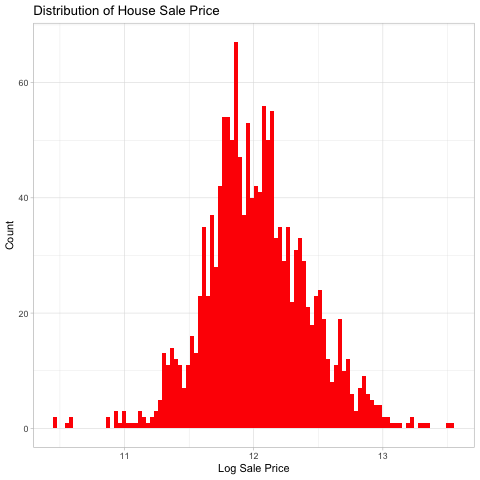

In [48]:
%%R -i price

ggplot(price, aes(x=SalePrice)) +
geom_histogram(fill='red', bins=100) +
labs(title='Distribution of House Sale Price',
     x='Log Sale Price',
     y='Count')

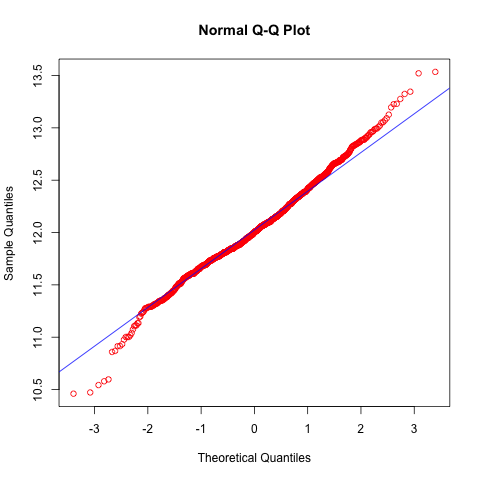

In [49]:
%%R -i price

qqnorm(price$SalePrice, col='red')
qqline(price$SalePrice, col='blue')

## Scaling and Encoding Variables

In [50]:
# Creating list of numerical and categorical features respectively
numerical_features = all_imputed.select_dtypes('number').columns.tolist()
numerical_features.remove('SalePrice')
categorical_features = all_imputed.select_dtypes('object').columns.tolist()

# Asserting all columns are selected
len(all_imputed.columns) - 1 == len(numerical_features) + len(categorical_features)

True

In [51]:
# Transform columns that might be inherently ordinal
ordinal_cols = ['FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 
        'OverallCond', 'YrSold', 'MoSold']

lbl = LabelEncoder()
all_imputed.loc[:, ordinal_cols] = all_imputed.loc[:, ordinal_cols].apply(lbl.fit_transform)

In [52]:
# Create boolean masks for train and test datasets
train_mask = all_imputed['SalePrice'].notnull()
test_mask = all_imputed['SalePrice'].isnull()

In [53]:
# Standardize the training set and testing set accordingly
std = StandardScaler()
scaler = std.fit(all_imputed.loc[train_mask, numerical_features])

# Use the fitted scale on train set onto test set to avoid leakage
all_imputed.loc[train_mask, numerical_features] = scaler.transform(
    all_imputed.loc[train_mask, numerical_features])
all_imputed.loc[test_mask, numerical_features] = scaler.transform(
    all_imputed.loc[test_mask, numerical_features])

In [54]:
# Dummification of remaining categorical variables
all_imputed = pd.get_dummies(all_imputed)

# Split the data back into train and test sets
train = all_imputed.loc[train_mask]
test = all_imputed.loc[test_mask]

In [55]:
# Prepare data for ML
X_train = train.drop(['SalePrice'], axis = 1)
y_train = train['SalePrice']

X_test = test.drop(['SalePrice'], axis = 1)

In [56]:
# Assert we have the same number of columns in X_train and X_test
X_train.shape[1] == X_test.shape[1]
print('We have {} columns in our dataset.'.format(X_train.shape[1]))

True

We have 221 columns in our dataset.


# Modelling

In [57]:
def rmse(cv):
    '''
    Prints the RMSE that is identical to Kaggle matrics.
    Used for GridSearchCV and RandomizedSearchCV.
    '''
    print('The lowest RMSE found: {}'.format(np.sqrt(np.abs(cv.best_score_))))
    
    
def cvsrmse(cv):
    '''
    Prints the RMSE that is identical to Kaggle matrics.
    Used for cross_val_score.
    '''
    print('The lowest RMSE found: {}'.format(np.sqrt(np.abs(cv.mean()))))

## Base Models

### Lasso

In [58]:
# Hyperparameters to tune
params = {'alpha': np.logspace(-5, -3, 201)}

# Instantiate the regressor
lasso = Lasso(warm_start=True)
lasso_cv = GridSearchCV(estimator=lasso, 
                        param_grid=params, 
                        cv=5, verbose=1, 
                        scoring='neg_mean_squared_error', 
                        n_jobs=-1)

lasso_cv.fit(X_train, y_train)

Fitting 5 folds for each of 201 candidates, totalling 1005 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   35.9s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   59.0s
[Parallel(n_jobs=-1)]: Done 1005 out of 1005 | elapsed:  1.2min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=True),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-05, 1.02329299e-05, 1.04712855e-05, 1.07151931e-05,
       1.096478...
       6.91830971e-04, 7.07945784e-04, 7.24435960e-04, 7.41310241e-04,
       7.58577575e-04, 7.76247117e-04, 7.94328235e-04, 8.12830516e-04,
       8.31763771e-04, 8.51138038e-04, 8.70963590e-04, 8.91250938e-04,
       9.12010839e-04, 9.33254301e-04, 9.54992586e-04, 9.77237221e-04,
       1.00000000e-03])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=1)

In [59]:
rmse(lasso_cv)
print('The best parameters found: ', lasso_cv.best_params_)
lasso_base = lasso_cv.best_estimator_

The lowest RMSE found: 0.11103374823792148
The best parameters found:  {'alpha': 0.00046773514128719813}


### Elastic-net

In [60]:
# Hyperparameters to tune
params = {'alpha': np.logspace(-4, -3, 101),
          'l1_ratio': np.linspace(0.9, 1, 101)}

# Instantiate the regressor
e_net = ElasticNet(warm_start=True)
e_net_cv = RandomizedSearchCV(estimator=e_net, 
                              param_distributions=params, 
                              cv=5, verbose=1, n_iter=500,
                              scoring='neg_mean_squared_error', 
                              n_jobs=-1, random_state=1)

e_net_cv.fit(X_train, y_train)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 219 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 469 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 819 tasks      | elapsed:   50.7s
[Parallel(n_jobs=-1)]: Done 1269 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1819 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 2469 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:  2.4min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=ElasticNet(alpha=1.0, copy_X=True,
                                        fit_intercept=True, l1_ratio=0.5,
                                        max_iter=1000, normalize=False,
                                        positive=False, precompute=False,
                                        random_state=None, selection='cyclic',
                                        tol=0.0001, warm_start=True),
                   iid='warn', n_iter=500, n_jobs=-1,
                   param_distributions={'alpha': array([0.0001    , 0.00010233, 0.0001...
       0.954, 0.955, 0.956, 0.957, 0.958, 0.959, 0.96 , 0.961, 0.962,
       0.963, 0.964, 0.965, 0.966, 0.967, 0.968, 0.969, 0.97 , 0.971,
       0.972, 0.973, 0.974, 0.975, 0.976, 0.977, 0.978, 0.979, 0.98 ,
       0.981, 0.982, 0.983, 0.984, 0.985, 0.986, 0.987, 0.988, 0.989,
       0.99 , 0.991, 0.992, 0.993, 0.994, 0.995, 0.996, 0.997, 0.998,
       0.999, 1

In [61]:
rmse(e_net_cv)
print('The best parameters found: ', e_net_cv.best_params_)
e_net_base = e_net_cv.best_estimator_

The lowest RMSE found: 0.11103479383295042
The best parameters found:  {'l1_ratio': 0.998, 'alpha': 0.0004570881896148752}


### Stochastic Gradient Boosting

In [62]:
# Hyperparameters to tune
params = {
    'loss': ['huber'],
    'n_estimators': [5000],
    'learning_rate': [0.01],
    'max_depth': [3, 4],
    'subsample': [0.7, 0.8, 0.9],
    'max_features': ['sqrt'],
    'min_samples_leaf': [5, 6, 7, 8, 9, 10],
    'min_samples_split': [15, 16, 17, 18, 19, 20], 
    'random_state': [1]
}

# Instantiate the regressor
gbr = GradientBoostingRegressor()
gbr_cv = RandomizedSearchCV(estimator=gbr,
                      param_distributions=params, 
                      cv=5, verbose=1, n_iter=30,
                      scoring='neg_mean_squared_error', 
                      n_jobs=-1)

gbr_cv.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  7.1min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=GradientBoostingRegressor(alpha=0.9,
                                                       criterion='friedman_mse',
                                                       init=None,
                                                       learning_rate=0.1,
                                                       loss='ls', max_depth=3,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                            

In [63]:
rmse(gbr_cv)
print('The best parameters found: ', gbr_cv.best_params_)
gbr_base = gbr_cv.best_estimator_

The lowest RMSE found: 0.108662258056165
The best parameters found:  {'subsample': 0.7, 'random_state': 1, 'n_estimators': 5000, 'min_samples_split': 19, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 3, 'loss': 'huber', 'learning_rate': 0.01}


### Kernel Ridge

In [64]:
# Hyperparameters to tune
params = {
    'alpha': np.linspace(0, 1, 101),
    'degree': np.linspace(1, 3, 201),
    'coef0': np.linspace(2, 4, 201),
    'kernel': ['polynomial']
}

# Instantiate the regressor
krr = KernelRidge()
krr_cv = RandomizedSearchCV(estimator=krr, 
                            param_distributions=params, 
                            cv=5, verbose=1, n_iter=500,
                            scoring='neg_mean_squared_error', 
                            n_jobs=-1, random_state=1)

krr_cv.fit(X_train, y_train)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:   45.2s
[Parallel(n_jobs=-1)]: Done 2198 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:  1.3min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
                                         kernel='linear', kernel_params=None),
                   iid='warn', n_iter=500, n_jobs=-1,
                   param_distributions={'alpha': array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0...
       2.54, 2.55, 2.56, 2.57, 2.58, 2.59, 2.6 , 2.61, 2.62, 2.63, 2.64,
       2.65, 2.66, 2.67, 2.68, 2.69, 2.7 , 2.71, 2.72, 2.73, 2.74, 2.75,
       2.76, 2.77, 2.78, 2.79, 2.8 , 2.81, 2.82, 2.83, 2.84, 2.85, 2.86,
       2.87, 2.88, 2.89, 2.9 , 2.91, 2.92, 2.93, 2.94, 2.95, 2.96, 2.97,
       2.98, 2.99, 3.  ]),
                                        'kernel': ['polynomial']},
                   pre_dispatch='2*n_jobs', random_state=1, refit=True,
                   return_train_s

In [65]:
rmse(krr_cv)
print('The best parameters found: ', krr_cv.best_params_)
krr_base = krr_cv.best_estimator_

The lowest RMSE found: 0.11156861825787802
The best parameters found:  {'kernel': 'polynomial', 'degree': 1.45, 'coef0': 3.71, 'alpha': 0.15}


### Extreme Gradient Boosting

#### Benchmark - Random Search

In [91]:
# Hyperparameters to tune
params = {
    'subsample': np.linspace(0.5, 0.9, 41),
    'colsample_bytree': np.linspace(0.1, 0.2, 11),
    'reg_lambda': np.linspace(0.5, 1, 51),
    'reg_alpha': np.linspace(0, 0.5, 51),
    'gamma': np.linspace(0, 0.1, 101),
    'min_child_weight': np.linspace(0.5, 2, 151)
}

# Instantiate the regressor
xgboo = xgb.XGBRegressor(
    objective = 'reg:squarederror',
    eval_metric = 'rmse',
    verbosity=1,
    n_estimators=2000,
    learning_rate=0.05,
    max_depth=3,
    n_jobs=4
)

xgboo_cv = RandomizedSearchCV(estimator=xgboo, 
                              param_distributions=params, 
                              cv=3, verbose=1, n_iter=500,
                              scoring='neg_mean_squared_error', 
                              n_jobs=4, random_state=1)
  
xgboo_cv.fit(X_train, y_train)

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  8.8min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed: 20.0min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed: 35.6min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed: 55.5min
[Parallel(n_jobs=4)]: Done 1500 out of 1500 | elapsed: 66.7min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1,
                                          eval_metric='rmse', gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.05, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=2000,
                                          n_jobs=4, nthread=None,
                                          objective='...
       0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.  ]),
                                        'subsample': array([0.5 , 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6 ,
       0.61,

In [94]:
rmse(xgboo_cv)
print('The best parameters found for RSCV: ', xgboo_cv.best_params_)

The lowest RMSE found: 0.11557069979523957
The best parameters found for RSCV:  {'subsample': 0.59, 'reg_lambda': 0.8300000000000001, 'reg_alpha': 0.0, 'min_child_weight': 1.07, 'gamma': 0.007, 'colsample_bytree': 0.15000000000000002}


In [135]:
# XGB model using Randomized Search Hyperparameters
xgboost_rm = xgb.XGBRegressor(subsample=0.59, gamma=0.007,
                              colsample_bytree=0.1684, min_child_weight=1.8642,
                              reg_alpha=0, reg_lambda=0.83,
                              n_estimators=5000, objective='reg:squarederror',
                              learning_rate=0.01, max_depth=3,
                              random_state=1)

cv_xgb_rm = cross_val_score(
    estimator=xgboost_rm, X=X_train, y=y_train, cv=5, scoring='neg_mean_squared_error')

xgboost_rm.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.1684, gamma=0.007,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=3, min_child_weight=1.8642, missing=None,
             n_estimators=5000, n_jobs=1, nthread=None,
             objective='reg:squarederror', random_state=1, reg_alpha=0,
             reg_lambda=0.83, scale_pos_weight=1, seed=None, silent=None,
             subsample=0.59, verbosity=1)

In [136]:
cvsrmse(cv_xgb_rm)

The lowest RMSE found: 0.11081461057954749


#### Bayesian Optimization

In [122]:
# Hyperparameters to tune
bds =  [
    {'name': 'subsample', 'type': 'continuous', 'domain': (0.6, 0.9)},
    {'name': 'gamma', 'type': 'continuous', 'domain': (0, 0.1)},
    {'name': 'colsample_bytree', 'type': 'continuous', 'domain': (0, 0.5)},
    {'name': 'max_depth', 'type': 'discrete', 'domain': (3, 5)},
    {'name': 'min_child_weight', 'type': 'continuous', 'domain': (1, 2)},
    {'name': 'reg_alpha', 'type': 'continuous', 'domain': (0, 0.5)},
    {'name': 'reg_lambda', 'type': 'continuous', 'domain': (0.5, 1)}
]

# Optimization objective function
def cv_score(parameters):
    parameters = parameters[0]
    score = cross_val_score(
                xgb.XGBRegressor(subsample=parameters[0],
                                 gamma=parameters[1],
                                 colsample_bytree=parameters[2],
                                 max_depth=int(parameters[3]),
                                 min_child_weight=parameters[4],
                                 reg_alpha=parameters[5],
                                 reg_lambda=parameters[6],
                                 n_estimators=3000,  
                                 learning_rate=0.02,
                                 n_jobs=6,
                                 objective='reg:squarederror'
                                 ), 
                X_train, y_train, scoring='neg_mean_squared_error').mean()
    score = np.array(score)
    return score

# Maximize negative MSE
optimizer = BayesianOptimization(cv_score, 
                                 domain=bds,
                                 acquisition_jitter=0.1,
                                 num_cores=2,
                                 maximize=True)

optimizer.run_optimization(max_iter=30)

In [141]:
y_bo = np.maximum.accumulate(-optimizer.Y).ravel()
print('The lowest RMSE found: {}'.format(np.sqrt(-y_bo)[-1]))

The lowest RMSE found: 0.11363620765378778


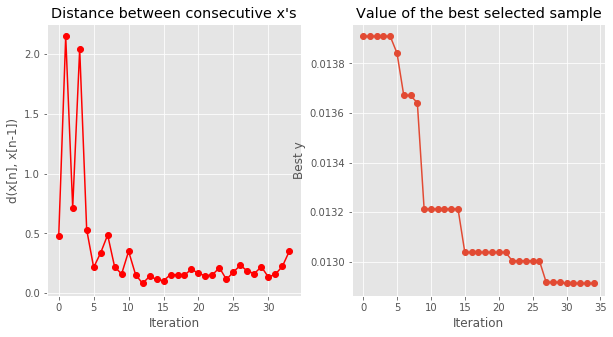

In [123]:
optimizer.plot_convergence()

In [67]:
# XGB model using Bayesian Optimization Hyperparameters
xgboost = xgb.XGBRegressor(subsample=0.8, gamma=0,
                           colsample_bytree=0.1684, min_child_weight=1.8642,
                           reg_alpha=0, reg_lambda=0.5162,
                           n_estimators=2500, objective='reg:squarederror',
                           learning_rate=0.04, max_depth=3,
                           random_state=1)

cv_xgb = cross_val_score(
    estimator=xgboost, X=X_train, y=y_train, cv=5, scoring='neg_mean_squared_error')

xgboost.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.1684, gamma=0,
             importance_type='gain', learning_rate=0.04, max_delta_step=0,
             max_depth=3, min_child_weight=1.8642, missing=None,
             n_estimators=2500, n_jobs=1, nthread=None,
             objective='reg:squarederror', random_state=1, reg_alpha=0,
             reg_lambda=0.5162, scale_pos_weight=1, seed=None, silent=None,
             subsample=0.8, verbosity=1)

In [68]:
cvsrmse(cv_xgb)

The lowest RMSE found: 0.11380023976233174


## Stacked Models

In [69]:
# Define base models and meta model
regressors = [e_net_base, gbr_base, krr_base]
lasso_meta = Lasso()

# Stacked model with xgb as meta model
stacked_regr = StackingRegressor(regressors=regressors,
                                 meta_regressor=lasso_meta,
                                 use_features_in_secondary=True)

# Hyperparameters to tune
params = {'meta_regressor__alpha': np.logspace(-5, -3, 101)}

stacked_cv = RandomizedSearchCV(estimator=stacked_regr, 
                                param_distributions=params,
                                cv=5, verbose=1, n_iter=20,
                                scoring='neg_mean_squared_error', 
                                n_jobs=-1)

stacked_cv.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.9min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=StackingRegressor(meta_regressor=Lasso(alpha=1.0,
                                                                    copy_X=True,
                                                                    fit_intercept=True,
                                                                    max_iter=1000,
                                                                    normalize=False,
                                                                    positive=False,
                                                                    precompute=False,
                                                                    random_state=None,
                                                                    selection='cyclic',
                                                                    tol=0.0001,
                                                                    warm_start=False),
              

In [70]:
rmse(stacked_cv)
print('The best parameters found: ', stacked_cv.best_params_)

The lowest RMSE found: 0.1095371461128822
The best parameters found:  {'meta_regressor__alpha': 0.0006606934480075965}


## Ensembling Estimates

In [172]:
def get_pred(fitted_model):
    '''
    Get predicted house price as a series.
    '''
    log_pred = fitted_model.predict(X_test)
    y_pred = np.expm1(log_pred)
    return y_pred


def prediction(fitted_model, model_name):
    '''
    Return rmse for prediction on the training data.
    '''
    pred = fitted_model.predict(X_train)
    rmse = np.sqrt(mean_squared_error(y_train, pred))
    print('The rmse for {} on the training set is {:.4f}.'.format(model_name, rmse))


def ensemble_price(price1, price2, prop_price1):
    '''
    Get ensemble price for prediction.
    price1: predicted sales price for first model as a Series
    price2: predicted sales price for second model as a Series
    prop_price1: proportion of first model
    '''
    return (price1*prop_price1 + price2*(1-prop_price1))


def sub(price, filename):
    """
    Create submission file for Kaggle.
    price: predicted sales price as a Series
    filename: filename as a quotted string
    """
    sub = pd.DataFrame()
    sub['Id'] = test_ID
    sub['SalePrice'] = price
    sub.to_csv(filename, index=False)

In [180]:
# Get stacked model prices
stacked_price = get_pred(stacked_cv)
xgb_price = get_pred(xgboost)
xgb_rm_price = get_pred(xgboost_rm)

# Get rmse for models
prediction(stacked_cv, 'Stack Model')
prediction(xgboost, 'XGBoost Model using Bayesian Optimization')
prediction(xgboost_rm, 'XGboost Model using Ramdomized Search')

The rmse for Stack Model on the training set is 0.0667.
The rmse for XGBoost Model using Bayesian Optimization on the training set is 0.0259.
The rmse for XGboost Model using Ramdomized Search on the training set is 0.0487.


In [183]:
# Get ensemble prices
price50 = ensemble_price(stacked_price, xgb_price, 0.5)
price55 = ensemble_price(stacked_price, xgb_rm_price, 0.55)
price60 = ensemble_price(stacked_price, xgb_rm_price, 0.60)
price65 = ensemble_price(stacked_price, xgb_rm_price, 0.65)
price70 = ensemble_price(stacked_price, xgb_rm_price, 0.70)
price75 = ensemble_price(stacked_price, xgb_rm_price, 0.75)

# Get submissions
sub(price50, '50stacked_xgb_rm')
sub(price55, '55stacked_xgb_rm')
sub(price60, '60stacked_xgb_rm')
sub(price65, '65stacked_xgb_rm')
sub(price70, '70stacked_xgb_rm')
sub(price75, '75stacked_xgb_rm')